# Refector Testing
A few pretty big changes here:

1. EIS now only has two channels. This means each cube at each timestep will be $N_x\times N_y\times N_{\lambda}$ where $N_{\lambda}\sim2000$. This means restructuring the `EISCube` object to handle bigger data.
  * Instrument response data changes
  * Reading instrument data changes
  * `EISCube` structure changes--don't subclass `MapCube`, implement a few of our own methods
2. Flattening emission data per transition when possible (e.g. with SDO AIA). This means **not** saving the emission per loop, but instead flattening over all transitions with the instrument response function. So emission is calculated at the flatten step.

In [1]:
import os
import subprocess
import sys
import logging
import pkg_resources
import json
import urllib
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import h5py
import astropy.units as u
import matplotlib.pyplot as plt
from sunpy.map import Map
import ChiantiPy.core as ch
import ChiantiPy.tools.util as ch_tools_util

import synthesizAR
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import EbtelInterface,calculate_free_energy
from synthesizAR.instruments import InstrumentHinodeEIS,InstrumentSDOAIA

%matplotlib inline

 using cli
 using CLI for selections
 reading chiantirc file


/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Field and Loop Simulations
Extrapolate the field and create the loop objects.

In [2]:
ar_root = '/data/datadrive2/ar_viz/emission_refactor_testing/'

In [ ]:
crop = (u.Quantity([-400,-140]*u.arcsec),u.Quantity([320,540]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton('/home/wtb2/sunpy/data/hmi_m_45s_2010_06_19_03_06_00_tai_magnetogram.0.fits',
                             crop=crop,resample=resample)

In [ ]:
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(50,loop_length_range=[1e+9,1e+11]*u.cm)

In [ ]:
field.make_loops()

Do the hydrodynamic simulations.

In [ ]:
class NanoflareStormModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        np.random.seed()
        
    @property
    def number_events(self):
        return 1
    
    def calculate_event_properties(self,loop):
        available_energy = calculate_free_energy(loop.field_aligned_coordinate,loop.field_strength,
                                                 stress_level=self.heating_options['stress_level'])
        rate = 2.0*available_energy/(self.number_events*(2.0*self.heating_options['duration'] 
                                                         - self.heating_options['duration_rise'] 
                                                         - self.heating_options['duration_decay']))
        #distribute start times randomly between 0 and total_time - duration
        tsr = np.random.rand(self.number_events)*(self.base_config['total_time'] - self.heating_options['duration'])
        ter = tsr + self.heating_options['duration_rise']
        tsd = ter + (self.heating_options['duration'] 
                     - self.heating_options['duration_rise'] 
                     - self.heating_options['duration_decay'])
        ted = tsr + self.heating_options['duration']
        return {'magnitude':np.array([rate]),'rise_start':tsr,'rise_end':ter,'decay_start':tsd,'decay_end':ted}

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.15,
}
heating_model = NanoflareStormModel(heating_options)
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 5000.0
ebtel_plug = EbtelInterface(base_config,heating_model,
                            os.path.join(ar_root,'hydro_config'),
                            os.path.join(ar_root,'hydro_results'))

In [ ]:
field.configure_loop_simulations(ebtel_plug)

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

And save the field.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

Reload the field here if needed.

In [3]:
field  = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

yt : [INFO     ] 2017-02-26 02:15:43,530 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-02-26 02:15:43,531 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-02-26 02:15:43,532 Parameters: domain_left_edge          = [ -2.89511786e+10   2.37893407e+10   4.40182588e+08]
yt : [INFO     ] 2017-02-26 02:15:43,533 Parameters: domain_right_edge         = [ -1.06601257e+10   3.93100982e+10   1.05643821e+10]
yt : [INFO     ] 2017-02-26 02:15:43,533 Parameters: cosmological_simulation   = 0.0


## Emission
First, grab the transitions that we actually want to resolve.

In [ ]:
new_linelist = [list(filter(None,line.decode('utf-8').strip('\n').split(' '))) \
                for line in urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt').readlines()[19:]]
resolved_transitions = []
for line in new_linelist:
    if int(line[0]) == 1 and line[1] == 'EIS':
        el = line[2]
        ion = line[3]
        wvl = float(line[4])
        el_ion = ch_tools_util.spectroscopic2name(el,ion)
        try:
            index = next(index for (index, d) in enumerate(resolved_transitions) if d["name"] == el_ion)
            resolved_transitions[index]['wavelengths'] = (list(resolved_transitions[index]['wavelengths'].value) + [wvl])*u.angstrom
        except StopIteration:
            resolved_transitions.append({'name':el_ion,'wavelengths':[wvl]*u.angstrom})
resolved_transitions.pop(1)

And check them versus Chianti to make sure the wavelengths are right.

In [ ]:
for ion in resolved_transitions:
    print('ion {}'.format(ion['name']))
    ch_ion = ch.ion(ion['name'])
    tmp = []
    for i,w in enumerate(ion['wavelengths'].value):
        new_wvl = min(ch_ion.Wgfa['wvl'],key=lambda x:abs(x-w))
        if abs(new_wvl - w)>0.1:
            raise ValueError('Closest wavelength {} is not within tolerance of {}'.format(new_wvl,w))
        tmp.append(new_wvl)
    tmp = tmp*ion['wavelengths'].unit
    ion['wavelengths'] = tmp

Now create the ion masterlist. 

In [ ]:
ion_masterlist = []
wvl_range = [80.0,350.0]
for ion in resolved_transitions:
    print('Building list for {}'.format(ion['name']))
    tmp = {'name':ion['name']}
    ci = ch.ion(ion['name'])
    wvls = [w for w in ci.Wgfa['wvl'] if wvl_range[0] <= w <= wvl_range[1]]
    wvls = wvls*u.angstrom
    tmp['wavelengths'] = wvls
    tmp['resolve_wavelength'] = [True if w in ion['wavelengths'] else False for w in wvls]
    ion_masterlist.append(tmp)

Now create the emission model for our list of ions.

In [ ]:
emiss_model = EmissionModel(ion_masterlist,density=np.logspace(8,11,20)/(u.cm**3),
                            energy_unit='photon',chianti_db_filename=os.path.join(ar_root,'chianti_db.h5'))

Or restore it from a save.

In [4]:
emiss_model = EmissionModel.restore(os.path.join(ar_root,'checkpoint_emiss_model'))

INFO:EmissionModel:Using CHIANTI HDF5 database in /data/datadrive2/ar_viz/emission_refactor_testing/chianti_db.h5
INFO:EmissionModel:Creating ion si_7
INFO:EmissionModel:Creating ion fe_10
INFO:EmissionModel:Creating ion fe_11
INFO:EmissionModel:Creating ion fe_12
INFO:EmissionModel:Creating ion fe_13
INFO:EmissionModel:Creating ion fe_15
INFO:EmissionModel:Creating ion s_13
INFO:EmissionModel:Creating ion fe_16
INFO:EmissionModel:Creating ion ca_17
INFO:EmissionModel:Restoring emission model from /data/datadrive2/ar_viz/emission_refactor_testing/checkpoint_emiss_model


Now calculate the emissivity for each of the selected transitions

In [ ]:
emiss_model.calculate_emissivity()

Save the emission model.

In [ ]:
emiss_model.save(savedir=os.path.join(ar_root,'checkpoint_emiss_model'))

Now calculate the fractional ionization, incorporating NEI.

In [ ]:
field.calculate_fractional_ionization(emiss_model,ebtel_plug,
                                      savefile=os.path.join(ar_root,'nei_populations.h5'))

And now calculate the emission for each loop. However, now we need to declare our instruments (or at least the imaging ones) first.

In [5]:
eis = InstrumentHinodeEIS([0,4990]*u.s)
aia = InstrumentSDOAIA([0,4990]*u.s,use_temperature_response_functions=False)

In [ ]:
field.calculate_emission(emiss_model,savefile=os.path.join(ar_root,'loop_emiss.h5'),imagers=[aia])

In [ ]:
field.loops[0].get_emission(emiss_model.resolved_wavelengths[0].value)

In [ ]:
plt.plot(field.loops[0].time,field.loops[0].get_emission('{}_{}'.format(aia.name,aia.channels[4]['name']))[:,0])
#plt.xlim([3800,4100])
plt.yscale('log')

## Observe
Now configure the observer object and build data products.

First, remove the channels that we don't need from the eis detector.

In [6]:
observer = synthesizAR.Observer(field,[aia,eis],ds=field._convert_angle_to_length(0.5*u.arcsec))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [7]:
observer.build_detector_files(ar_root)

INFO:InstrumentSDOAIA:Creating instrument file /data/datadrive2/ar_viz/emission_refactor_testing/SDO_AIA_counts.h5
INFO:InstrumentHinodeEIS:Creating instrument file /data/datadrive2/ar_viz/emission_refactor_testing/Hinode_EIS_counts.h5


In [ ]:
observer.flatten_detector_counts()

In [9]:
observer.instruments = [eis]

In [10]:
observer.bin_detector_counts(ar_root)

INFO:Observer:Building data products for Hinode_EIS


KeyboardInterrupt: 

In [19]:
test_cube = synthesizAR.util.EISCube(os.path.join(ar_root,'Hinode_EIS','170-210','map_t000023.fits'))

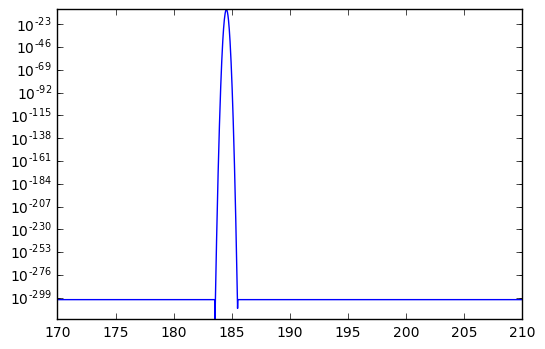

In [20]:
plt.plot(test_cube.wavelength,test_cube.data[53,125,:])
plt.yscale('log')

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


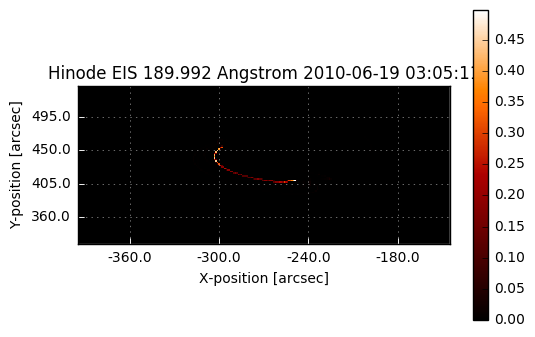

In [21]:
test_cube.integrated_intensity.peek()

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


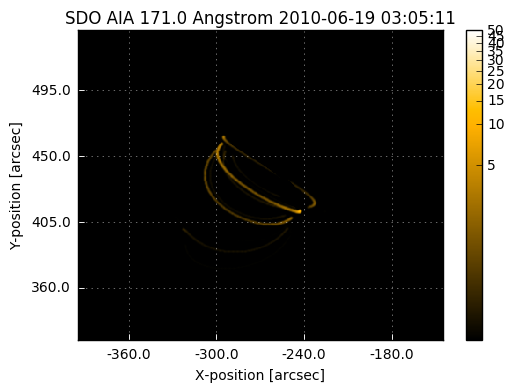

In [39]:
Map('/data/datadrive2/ar_viz/emission_refactor_testing/SDO_AIA/171/map_t000490.fits').peek(vmin=0.01,vmax=50)

In [43]:
eis.channels[0]['model_wavelengths']

<Quantity [ 184.537 , 188.216 , 192.394 , 192.8532, 195.119 , 202.044 ,
            203.826 ] Angstrom>

In [44]:
eis.channels[0]['response']['x']

<Quantity [ 170.   , 170.022, 170.045,...,  209.939, 209.962, 209.984] Angstrom>

In [92]:
trimmed_indices = []
tol = 0.5*u.angstrom
for x in eis.channels[0]['model_wavelengths']:
    indices = np.where(np.logical_and(eis.channels[0]['response']['x']>=x-tol,
                                      eis.channels[0]['response']['x']<=x+tol))
    trimmed_indices += indices[0].tolist()

In [93]:
trimmed_indices = list(sorted(set(trimmed_indices+[0,len(eis.channels[0]['response']['x'])-1])))

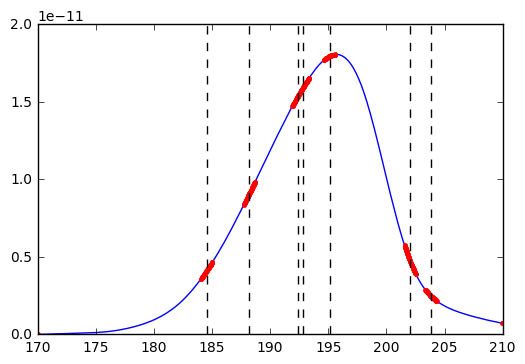

In [94]:
plt.plot(eis.channels[0]['response']['x'],eis.channels[0]['response']['y'],'b')
plt.plot(eis.channels[0]['response']['x'][trimmed_indices],eis.channels[0]['response']['y'][trimmed_indices],'.r')
for mw in eis.channels[0]['model_wavelengths']:
    plt.axvline(x=mw.value,linestyle='--',color='k')

In [91]:
for ion in emiss_model.ions:
    print([w for w in ion['transitions']*ion['resolve_wavelength'] if w>0.])

[<Quantity 275.3612 Angstrom>]
[<Quantity 184.537 Angstrom>]
[<Quantity 188.216 Angstrom>]
[<Quantity 192.394 Angstrom>, <Quantity 195.119 Angstrom>]
[<Quantity 202.044 Angstrom>, <Quantity 203.826 Angstrom>]
[<Quantity 284.163 Angstrom>]
[<Quantity 256.6852 Angstrom>]
[<Quantity 262.976 Angstrom>]
[<Quantity 192.8532 Angstrom>]
